## PCA and Classification Assignment

#### Anthony Buttitta

## Import Needed Modules

In [1]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import csv


#scikit learn imports
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

## Function Defintions

In [2]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [3]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
simplefilter("ignore", category=ConvergenceWarning)

## Source the Data

In [4]:
#download data files if not currently downloaded into the current working directory
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt8/"
filename = "In-VehicleCoupon.csv"

downloadDataResource(filename, path)

Data resource In-VehicleCoupon.csv already downloaded.


In [5]:
#create a dataframe with the data from the CSV file
data = pd.read_csv(filename)

## Explore the Data

In [6]:
data.income.head(20)

0     $37500 - $49999
1     $37500 - $49999
2     $37500 - $49999
3     $37500 - $49999
4     $37500 - $49999
5     $37500 - $49999
6     $37500 - $49999
7     $37500 - $49999
8     $37500 - $49999
9     $37500 - $49999
10    $37500 - $49999
11    $37500 - $49999
12    $37500 - $49999
13    $37500 - $49999
14    $37500 - $49999
15    $37500 - $49999
16    $37500 - $49999
17    $37500 - $49999
18    $37500 - $49999
19    $37500 - $49999
Name: income, dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passenger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

#Bar, CoffeeHouse, CarryAway, ResturantLessThan50, Restaurant20to50 have missingh values
data.dropna(inplace=True)

In [8]:
data.describe()

,temperature,has_children,toCoupon_5min,toCoupon_15min,toCoupon_25min,direction_same,direction_opp,AcceptCoupon
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
data.corr()

,temperature,has_children,toCoupon_5min,toCoupon_15min,toCoupon_25min,direction_same,direction_opp,AcceptCoupon
temperature,1.000000,-0.019716,NaN,-0.155332,-0.216254,0.097085,-0.097085,0.061240
has_children,-0.019716,1.000000,NaN,0.078211,-0.013722,-0.031620,0.031620,-0.045557
toCoupon_5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toCoupon_15min,-0.155332,0.078211,NaN,1.000000,0.324984,-0.303533,0.303533,-0.081602
toCoupon_25min,-0.216254,-0.013722,NaN,0.324984,1.000000,-0.192319,0.192319,-0.103633
direction_same,0.097085,-0.031620,NaN,-0.303533,-0.192319,1.000000,-1.000000,0.014570
direction_opp,-0.097085,0.031620,NaN,0.303533,0.192319,-1.000000,1.000000,-0.014570
AcceptCoupon,0.061240,-0.045557,NaN,-0.081602,-0.103633,0.014570,-0.014570,1.000000


<AxesSubplot:>

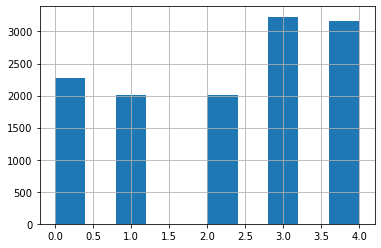

In [71]:
data.time.hist()

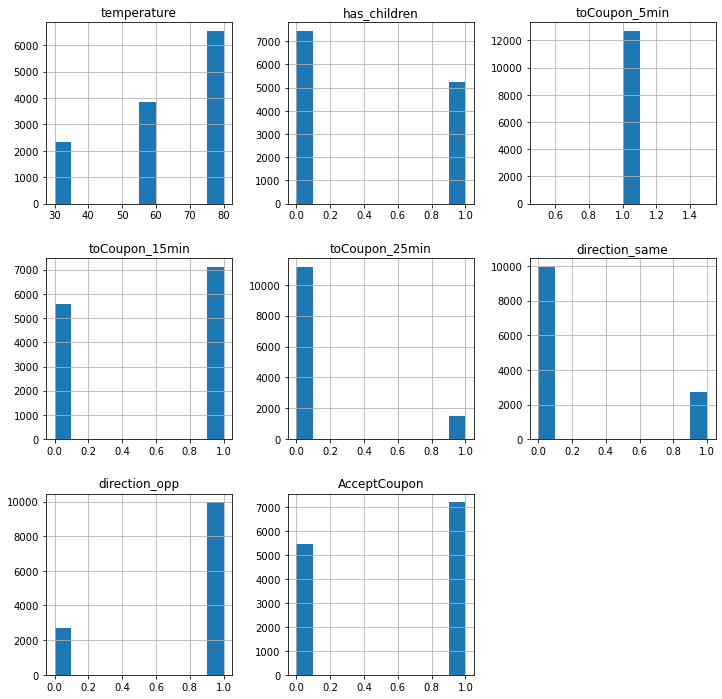

In [10]:
data.hist(figsize=(12,12))
plt.show()

<AxesSubplot:>

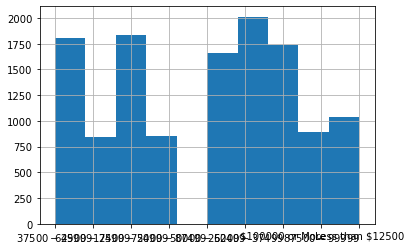

In [11]:
data.income.hist()

In [12]:
data.Bar.describe()

count     12577
unique        5
top       never
freq       5197
Name: Bar, dtype: object

In [13]:
data.Bar.value_counts()

never    5197
less1    3482
1~3      2473
4~8      1076
gt8       349
Name: Bar, dtype: int64

In [14]:
data.RestaurantLessThan20.value_counts()

1~3      5376
4~8      3580
less1    2093
gt8      1285
never     220
Name: RestaurantLessThan20, dtype: int64

## Transform the Data

In [15]:
imputer = SimpleImputer(strategy='constant',
                        missing_values=np.nan, fill_value='NaN')
imputer = imputer.fit(data[['Bar','CoffeeHouse', 'CarryAway','RestaurantLessThan20',"Restaurant20To50"]])
data[['Bar','CoffeeHouse','CarryAway','RestaurantLessThan20',"Restaurant20To50"]]

,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,never,never,NaN,4~8,1~3
1,never,never,NaN,4~8,1~3
2,never,never,NaN,4~8,1~3
3,never,never,NaN,4~8,1~3
4,never,never,NaN,4~8,1~3
...,...,...,...,...,...
12679,never,never,1~3,4~8,1~3
12680,never,never,1~3,4~8,1~3
12681,never,never,1~3,4~8,1~3
12682,never,never,1~3,4~8,1~3


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passenger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

In [17]:
#create an ordinal encorder object and fit the attribte
#ord_attribs = ['weather', 'temperature', 'time', 'age', 'education', 'income']

ordinal_encoder = OrdinalEncoder()
data['weather'] = ordinal_encoder.fit_transform(data[['weather']])
data['temperature'] = ordinal_encoder.fit_transform(data[['temperature']])
data['time'] = ordinal_encoder.fit_transform(data[['time']])
data['age'] = ordinal_encoder.fit_transform(data[['age']])
data['education'] = ordinal_encoder.fit_transform(data[['education']])
data['income'] = ordinal_encoder.fit_transform(data[['income']])

In [68]:
#create an ordinal encorder object and fit the attribte
ordinal_encoder = OrdinalEncoder()
data['Accept_Coupon'] = ordinal_encoder.fit_transform(data[['AcceptCoupon']])

In [69]:
AcceptCouponCode = ordinal_encoder.categories_
AcceptCouponCode

[array([0, 1], dtype=int64)]

In [20]:
data.gender.head(10)

0    Female
1    Female
2    Female
3    Female
4    Female
5    Female
6    Female
7    Female
8    Female
9    Female
Name: gender, dtype: object

In [21]:
#replace yes/no columns with binary (0/1) values
data['Gender'] = data.apply(lambda x: 0 if x.gender=="Female" else 1, axis=1)
data.drop(columns=['gender'], inplace=True)

In [22]:
data.Gender.value_counts()

0    6511
1    6173
Name: Gender, dtype: int64

In [23]:
data.Gender.describe()

count    12684.000000
mean         0.486676
std          0.499842
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Gender, dtype: float64

In [24]:
data.destination.head()

0    No Urgent Place
1    No Urgent Place
2    No Urgent Place
3    No Urgent Place
4    No Urgent Place
Name: destination, dtype: object

In [25]:
data.head(20)

,destination,passenger,weather,temperature,time,coupon,expiration,age,maritalStatus,has_children,...,RestaurantLessThan20,Restaurant20To50,toCoupon_5min,toCoupon_15min,toCoupon_25min,direction_same,direction_opp,AcceptCoupon,CouponCode,Gender
0,No Urgent Place,Alone,2.0,1.0,2.0,Restaurant(<20),1d,0.0,Unmarried partner,1,...,4~8,1~3,1,0,0,0,1,1,4.0,0
1,No Urgent Place,Friend(s),2.0,2.0,0.0,Coffee House,2h,0.0,Unmarried partner,1,...,4~8,1~3,1,0,0,0,1,0,2.0,0
2,No Urgent Place,Friend(s),2.0,2.0,0.0,Carry out & Take away,2h,0.0,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,1,1.0,0
3,No Urgent Place,Friend(s),2.0,2.0,2.0,Coffee House,2h,0.0,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,0,2.0,0
4,No Urgent Place,Friend(s),2.0,2.0,2.0,Coffee House,1d,0.0,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,0,2.0,0
5,No Urgent Place,Friend(s),2.0,2.0,3.0,Restaurant(<20),2h,0.0,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,1,4.0,0
6,No Urgent Place,Friend(s),2.0,1.0,2.0,Carry out & Take away,1d,0.0,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,1,1.0,0
7,No Urgent Place,Kid(s),2.0,2.0,0.0,Restaurant(<20),2h,0.0,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,1,4.0,0
8,No Urgent Place,Kid(s),2.0,2.0,0.0,Carry out & Take away,2h,0.0,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,1,1.0,0
9,No Urgent Place,Kid(s),2.0,2.0,0.0,Bar,1d,0.0,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,0,0.0,0


## Create Training and Test data sets

### Split the data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['AcceptCoupon']), 
    data.AcceptCoupon, 
    test_size=.2, 
    random_state=32,
)

In [27]:
#display sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10147, 25), (2537, 25), (10147,), (2537,))

## Prepare the Data

### Build Transformation Pipeline

In [28]:
ord_attribs = ['weather', 'temperature', 'time', 'age', 'education', 'income']

cat_attribs = ["destination", "passenger", 'coupon', 'expiration', 'Gender', 'maritalStatus', 'occupation', 'Bar' , 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

non_num = ord_attribs + cat_attribs

num_attribs = list( X_train.drop(columns= non_num))

num_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),   
] )

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
   # ('ord', ord_pipeline1, ord_attribs)
    ('cat', OneHotEncoder(sparse=False), cat_attribs)
])

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   destination           12684 non-null  object 
 1   passenger             12684 non-null  object 
 2   weather               12684 non-null  float64
 3   temperature           12684 non-null  float64
 4   time                  12684 non-null  float64
 5   coupon                12684 non-null  object 
 6   expiration            12684 non-null  object 
 7   age                   12684 non-null  float64
 8   maritalStatus         12684 non-null  object 
 9   has_children          12684 non-null  int64  
 10  education             12684 non-null  float64
 11  occupation            12684 non-null  object 
 12  income                12684 non-null  float64
 13  Bar                   12577 non-null  object 
 14  CoffeeHouse           12467 non-null  object 
 15  CarryAway          

### Create X data sets

In [30]:
X_train = full_pipeline.fit_transform( X_train )
X_test = full_pipeline.transform( X_test )

X_train.shape, X_test.shape

((10147, 83), (2537, 83))

In [31]:
#preserve column names for One Hot Encoded columns
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = []
if hasattr(cat_encoder, 'categories_'):
    for i in cat_encoder.categories_:
        cat_one_hot_attribs += list (i) 

#combines the numeric and encoded features
attributes = list(num_attribs) + list(cat_one_hot_attribs)

#display the attributes
attributes

['has_children',
 'toCoupon_5min',
 'toCoupon_15min',
 'toCoupon_25min',
 'direction_same',
 'direction_opp',
 'CouponCode',
 'Home',
 'No Urgent Place',
 'Work',
 'Alone',
 'Friend(s)',
 'Kid(s)',
 'Partner',
 'Bar',
 'Carry out & Take away',
 'Coffee House',
 'Restaurant(20-50)',
 'Restaurant(<20)',
 '1d',
 '2h',
 0,
 1,
 'Divorced',
 'Married partner',
 'Single',
 'Unmarried partner',
 'Widowed',
 'Architecture & Engineering',
 'Arts Design Entertainment Sports & Media',
 'Building & Grounds Cleaning & Maintenance',
 'Business & Financial',
 'Community & Social Services',
 'Computer & Mathematical',
 'Construction & Extraction',
 'Education&Training&Library',
 'Farming Fishing & Forestry',
 'Food Preparation & Serving Related',
 'Healthcare Practitioners & Technical',
 'Healthcare Support',
 'Installation Maintenance & Repair',
 'Legal',
 'Life Physical Social Science',
 'Management',
 'Office & Administrative Support',
 'Personal Care & Service',
 'Production Occupations',
 'Protec

## Logistic Regression Model

#### Train and Evaluate Model using Training Data

In [32]:
# Train the logistic regression model
log_reg = LogisticRegression(multi_class='multinomial')

#fit the model to the training data
log_reg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [33]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = log_reg.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 68.23%


In [34]:
#use cross valudation to process the data 10 different ways using the logsitic regression model generated above
scores = cross_val_score(log_reg, X_train, y_train, cv=10)

# look at average across all folds
print('Accuracy: {:.2f}%'.format( scores.mean()*100 ) )

Accuracy: 67.52%


#### Evaluate Model on Test Set

In [35]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = log_reg.score(X_test, y_test)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 68.86%


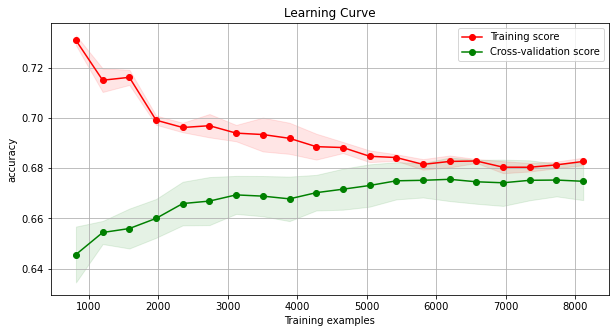

In [36]:
plot_learning_curve(log_reg, X_train, y_train, scoring='accuracy')

## Tune LogistcRegression Model

In [37]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'solver': ['saga', 'newton-cg', 'lbfgs', 'sag'],
     'multi_class': ['ovr', 'multinomial'],
     'C': [.5, 1, 2]
    }
]

# train across 10 folds, that's a total of (4*6)*10=240 rounds of training 
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': [0.5, 1, 2],
                          'multi_class': ['ovr', 'multinomial'],
                          'solver': ['saga', 'newton-cg', 'lbfgs', 'sag']}],
             return_train_score=True, scoring='accuracy')

In [38]:
#display the results of the GridSearchCV
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("Accuracy: {:,.2f}% - {}".format( mean_score*100, params) )

Accuracy: 67.52% - {'C': 0.5, 'multi_class': 'ovr', 'solver': 'saga'}
Accuracy: 67.52% - {'C': 0.5, 'multi_class': 'ovr', 'solver': 'newton-cg'}
Accuracy: 67.49% - {'C': 0.5, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Accuracy: 67.51% - {'C': 0.5, 'multi_class': 'ovr', 'solver': 'sag'}
Accuracy: 67.55% - {'C': 0.5, 'multi_class': 'multinomial', 'solver': 'saga'}
Accuracy: 67.55% - {'C': 0.5, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Accuracy: 67.55% - {'C': 0.5, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Accuracy: 67.53% - {'C': 0.5, 'multi_class': 'multinomial', 'solver': 'sag'}
Accuracy: 67.55% - {'C': 1, 'multi_class': 'ovr', 'solver': 'saga'}
Accuracy: 67.55% - {'C': 1, 'multi_class': 'ovr', 'solver': 'newton-cg'}
Accuracy: 67.55% - {'C': 1, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Accuracy: 67.55% - {'C': 1, 'multi_class': 'ovr', 'solver': 'sag'}
Accuracy: 67.53% - {'C': 1, 'multi_class': 'multinomial', 'solver': 'saga'}
Accuracy: 67.53% - {'C': 1, 'multi_class': 'm

In [39]:
#display the best solution
grid_search.best_params_

{'C': 0.5, 'multi_class': 'multinomial', 'solver': 'saga'}

### Create the best LogsiticRegression Model

In [40]:
#use the parameters found above to create the model
model = LogisticRegression(**grid_search.best_params_)

#fit the model to the training data set
model.fit(X_train, y_train)

#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = model.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 68.21%


In [41]:
#use cross valudation to process the data 10 different ways using linear regression model generated above
scores = cross_val_score(model, X_train, y_train, cv=10)

# look at average across all folds
print('Accuracy: {:.2f}%'.format( scores.mean()*100 ) )

Accuracy: 67.55%


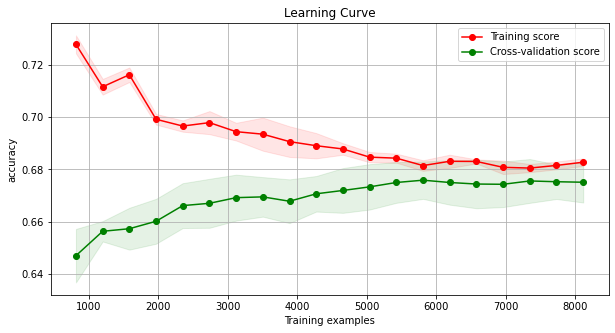

In [42]:
plot_learning_curve(model, X_train, y_train, scoring='accuracy')

### Evaluate Model on Test Set

In [43]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = model.score(X_test, y_test)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 68.94%


In [44]:
#get predictions across 5 different folds using the default method (prediciton scores)
y_test_pred = cross_val_predict(model, X_test, y_test, cv=5)

conf_mat = confusion_matrix(y_test, y_test_pred)
conf_mat

array([[ 575,  465],
       [ 330, 1167]], dtype=int64)

## Add complexity using PolynomialFeatures

In [45]:
#try making a linear model fit data that is more likely non-linear
DEGREE = 2

#create a polynomial feature with degree based on variable DEGREE
poly_features=PolynomialFeatures(degree=DEGREE)

#transform our X by adding the square of each feature to the training set
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

X_train_poly.shape, X_test_poly.shape

((10147, 3570), (2537, 3570))

In [46]:
# use the new, complex data set to train a new model
model_poly = LogisticRegression()

model_poly.fit(X_train_poly, y_train)

#compare the predicted to the actuals
acc = model_poly.score(X_train_poly, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 80.83%


In [47]:
#use cross valudation to process the data 10 different ways using linear regression model generated above
scores = cross_val_score(model_poly, X_train_poly, y_train, cv=10)

# look at average across all folds
print('Accuracy: {:.2f}%'.format( scores.mean()*100 ) )

Accuracy: 73.64%


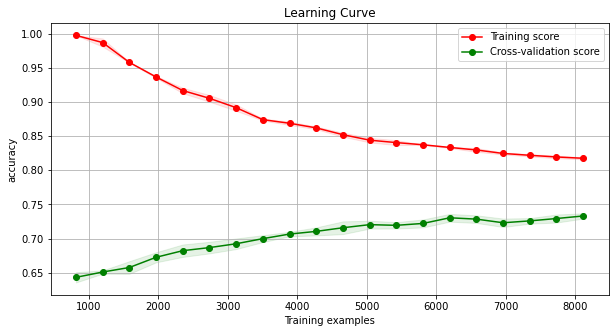

In [48]:
plot_learning_curve(model_poly,X_train_poly,y_train, scoring="accuracy")

In [49]:
#calcualte the predicted values
predictions = model_poly.predict(X_test_poly)

#compare the predicted to the actuals
print(" Accuracy Score: {:.2f}%".format( accuracy_score(y_test, predictions )*100 ))

 Accuracy Score: 72.68%


## PCA Analysis

In [50]:
pca = PCA(n_components=.95)
X_train_reduced = pca.fit_transform(X_train)
X_train_reduced.shape

(10147, 37)

In [51]:
X_test_reduced = pca.transform(X_test)

In [52]:
X_test_reduced.shape

(2537, 37)

## Best Model with PCA

In [53]:
#use the parameters found above to create the model
PCA_model = model_poly

#fit the model to the training data set
PCA_model.fit(X_train_reduced, y_train)

#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = PCA_model.score(X_train_reduced, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 67.69%


In [54]:
scores = cross_val_score(PCA_model, X_train_reduced, y_train, cv=10)
scores.mean()
print('Accuracy: {:.2f}%'.format(scores.mean()*100))

Accuracy: 67.40%


In [55]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = PCA_model.score(X_test_reduced, y_test)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 68.78%


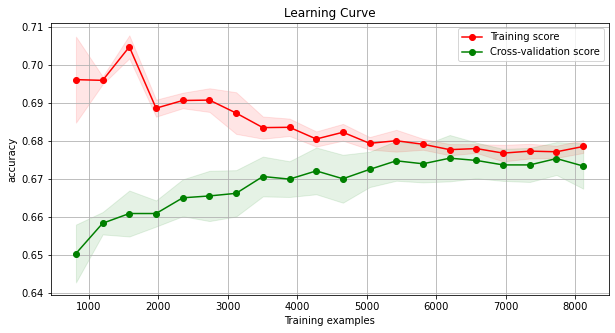

In [56]:
plot_learning_curve(log_reg, X_train_reduced, y_train, scoring="accuracy")

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [57]:
#create a t-SNE model
tsne = TSNE(n_components=2, init='random', learning_rate=1000)

#fit the first n test data to this model
tsne_data = tsne.fit_transform(X_train_poly)

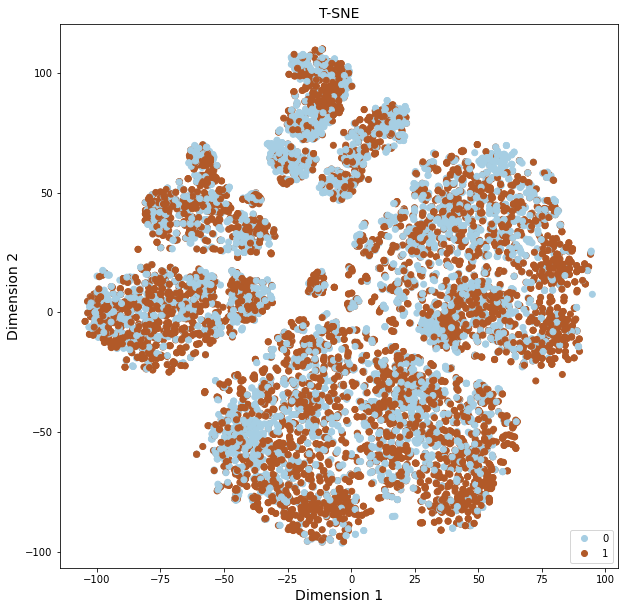

In [70]:
# Ploting the result of tsne
plt.figure(figsize=(10,10))
p = plt.scatter( tsne_data[:,0], tsne_data[:,1], c=y_train, cmap = cm.Paired)
plt.legend(handles=p.legend_elements()[0], labels=list(AcceptCouponCode[0]), loc="lower right", fontsize=10)   
plt.title('T-SNE',fontsize=14)
plt.xlabel("Dimension 1", fontsize=14)
plt.ylabel("Dimension 2", fontsize=14)            
plt.show()